In [1]:
import numpy as np
import h5py as h5
import pandas as pd
import scipy
from scipy import stats
import pickle
import re
import collections
import tables as tb
from math import isnan
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [ ]:
#when changing from sops to prime, change:
# 1. csv_file 
# 2.csv_data column number
# 3. exp name if saving the pkl file
# 4. exp_setup_path

In [2]:
baseline_dir = '/projects/rutwik/PNC/ML/'  #Directory where you have all your data
#csv_file = 'data/MD/PRIME/12Up/PNC_ML_LIST_MD_PRIME_12Up.csv'  
csv_file = 'data/FA/PRIME/ALL/PNC_ML_LIST_PRIME.csv'  
csv_data = pd.read_csv(baseline_dir+csv_file)
all_feature_names = list(csv_data.columns)

In [105]:
# if using the masterlist without gaf score columns, range is 5:34
#3 is prime 4 is sops 5 is gafcurrent(only in new masterlist)

start_col_idx = 5
end_col_idx = 34
label_col_idx = 3 #y values

feature_cols = csv_data.columns[start_col_idx:end_col_idx] 
feature_names = all_feature_names[start_col_idx:end_col_idx]
label_col = csv_data.columns[label_col_idx]

handpick_cols = True

#handpicked_list = [0,6,12,13,14,16,18,25] #MD
handpicked_list = [0,2,3,4,6,9,10,11,13,15,20,22,25,28] #MD
if handpick_cols:
    X = csv_data[feature_cols].values[:,handpicked_list]
    feature_names = [feature_names[i] for i in handpicked_list]
else:
    X = csv_data[feature_cols].values
    
y = csv_data[label_col].values


#print feature_cols
print 'X shape: {}, y shape: {}'.format(X.shape, y.shape)
print 'Mean of each feature across all subjects: {}:'.format(np.mean(X, axis=0))
print 'y_mean: {}, y_std:{}'.format(np.mean(y),np.std(y))
#print 'y_cutoff_low: {}, y_cutoff_high:{}'.format(np.mean(y)-1*np.std(y),np.mean(y)+1*np.std(y))

#Remove outliers based on extreme y scores 
y_cutoff_min = 5
y_cutoff_max = 50

X = X[y>y_cutoff_min,:]
y = y[y>y_cutoff_min]
X = X[y<y_cutoff_max,:]
y = y[y<y_cutoff_max]



print 'X shape: {}, y shape: {}'.format(X.shape, y.shape)
print 'Mean of each feature across all subjects: {}:'.format(np.mean(X, axis=0))
print 'y_mean: {}'.format(np.mean(y))


X shape: (98, 14), y shape: (98,)
Mean of each feature across all subjects: [ 0.41893339  0.3146755   0.36494826  0.47825178  0.52544293  0.45924119
  0.46619215  0.50502627  0.51040135  0.55073913  0.31826684  0.48346208
  0.48923869  0.46662329]:
y_mean: 22.887755102, y_std:13.2417726887
y_cutoff_low: 9.64598241331, y_cutoff_high:36.1295277908
X shape: (85, 14), y shape: (85,)
Mean of each feature across all subjects: [ 0.41942039  0.31455305  0.36512986  0.47800661  0.52519885  0.45810181
  0.4661434   0.50477849  0.51123401  0.55178338  0.31732166  0.48225933
  0.48926731  0.46531491]:
y_mean: 23.4352941176


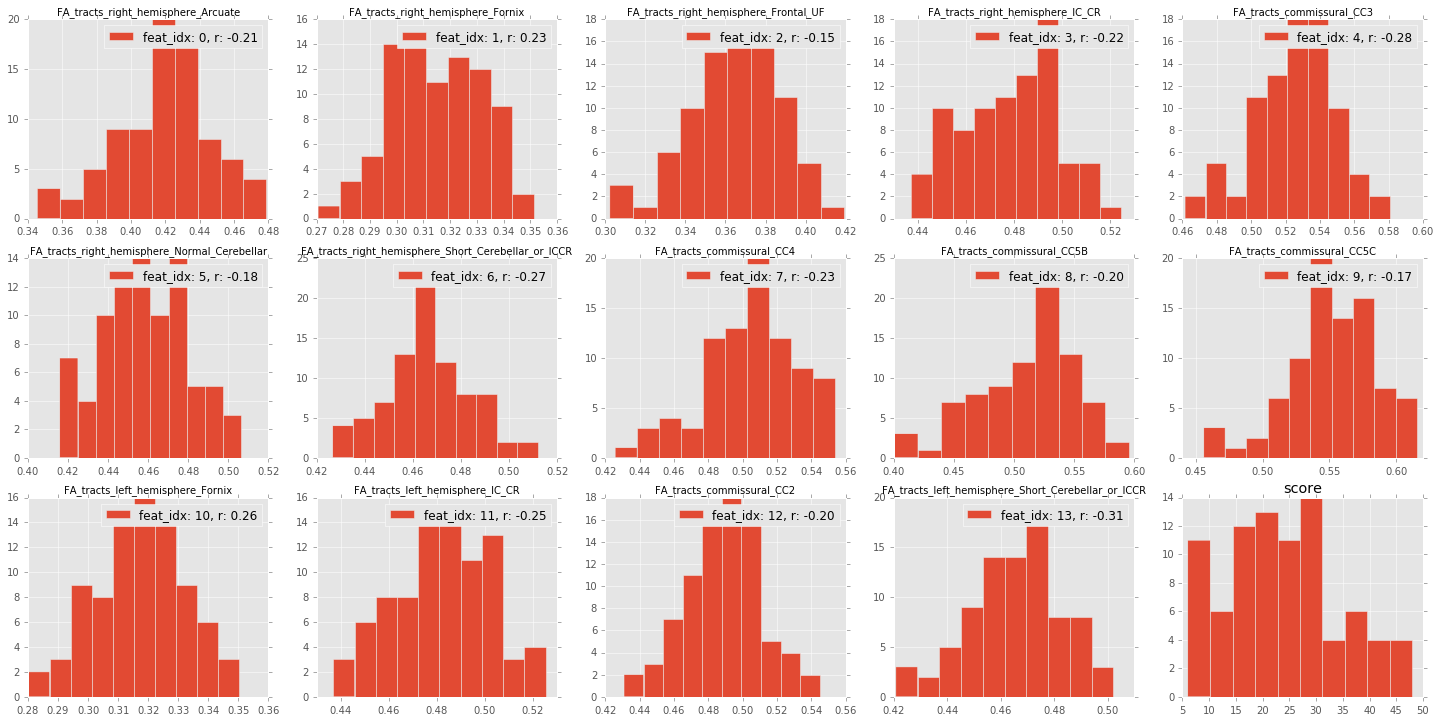

In [106]:
# Distribution plots for individual FA/MD tracts
plt.rcParams['figure.figsize'] = (25, 25)

for i in range(0,np.shape(X)[1]):
    univar_corr = pearsonr(X[:,i],y)
    plt.subplot(6,5,i+1)
    plt.hist(X[:,i],label = 'feat_idx: {}, r: {:03.2f}'.format(i, univar_corr[0]))
    plt.title(feature_names[i], fontsize=10)
    plt.legend()
    
plt.subplot(6,5,i+2)
plt.hist(y)
plt.title('score')
    


In [107]:
print len(handpicked_list)
feature_names


14


['FA_tracts_right_hemisphere_Arcuate',
 'FA_tracts_right_hemisphere_Fornix',
 'FA_tracts_right_hemisphere_Frontal_UF',
 'FA_tracts_right_hemisphere_IC_CR',
 'FA_tracts_commissural_CC3',
 'FA_tracts_right_hemisphere_Normal_Cerebellar',
 'FA_tracts_right_hemisphere_Short_Cerebellar_or_ICCR',
 'FA_tracts_commissural_CC4',
 'FA_tracts_commissural_CC5B',
 'FA_tracts_commissural_CC5C',
 'FA_tracts_left_hemisphere_Fornix',
 'FA_tracts_left_hemisphere_IC_CR',
 'FA_tracts_commissural_CC2',
 'FA_tracts_left_hemisphere_Short_Cerebellar_or_ICCR']

In [110]:
# Create folds for CV (default Stratified based on DX)
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold

stratified_KF = False
if not stratified_KF:
    print 'K-Fold type: {}'.format('Simple')
    kf = KFold(len(y), n_folds=5, shuffle=True, random_state=4)
else: 
    print 'K-Fold type: {}'.format('Stratified')
    kf = StratifiedKFold(y, n_folds=10)

print ''
print "fold-wise statstics of output variable (sanity check)"
fid = 0
for train_index, test_index in kf:    
    fid +=1 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
    print 'fold # {}, y_train_mean: {}, y_test_mean: {}, x_test: {}, x_train: {}'.format(fid, np.mean(y_train),np.mean(y_test),np.mean(X_test), np.mean(X_train) )
    
exp_name='FA_Prime_exp_5Fold_ALL_handpicked_features_subjects'
save_experimental_setup = False #Saves X, y, and KF
if save_experimental_setup:
    save_path = '/projects/nikhil/PNC/exp_setup/{}.pkl'.format(exp_name)
    exp_setup = {'X': X, 'y': y, 'kf':kf,'exp_name':exp_name,'feature_names':feature_names}
    pickleIt(exp_setup, save_path)
    print 'Saving experimental setup at : {}'.format(save_path)

K-Fold type: Simple

fold-wise statstics of output variable (sanity check)
fold # 1, y_train_mean: 23.0294117647, y_test_mean: 25.0588235294, x_test: 0.454443142857, x_train: 0.453220736345
fold # 2, y_train_mean: 23.8382352941, y_test_mean: 21.8235294118, x_test: 0.454907672269, x_train: 0.453104603992
fold # 3, y_train_mean: 23.4117647059, y_test_mean: 23.5294117647, x_test: 0.452097718487, x_train: 0.453807092437
fold # 4, y_train_mean: 23.5735294118, y_test_mean: 22.8823529412, x_test: 0.451690281513, x_train: 0.453908951681
fold # 5, y_train_mean: 23.3235294118, y_test_mean: 23.8823529412, x_test: 0.454187273109, x_train: 0.453284703782
Saving experimental setup at : /projects/nikhil/PNC/exp_setup/FA_Prime_exp_5Fold_ALL_handpicked_features_subjects.pkl


In [18]:
#import things that are used for linear regression 

# Configs for K-fold validations (nested) edited for regression
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
#import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Train and Test models
from functools import partial #Parallelize!!! 
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp
#from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline
plt.style.use('ggplot')

In [93]:
#defining the function 
def score_predict(X_train,X_test,y_train,y_test,model,hyper_params):
    #call the innerloop function within this function 
    optimal_model=innerCVLoop(model,hyper_params,X_train, y_train)      
    optimal_model.fit(X_train,y_train)
    y_prediction= optimal_model.predict(X_test)        
    return y_prediction

#inner loop function, converts the original trainset into train and validation
def innerCVLoop(model_clf,hyper_params,X_train, y_train):    
    from sklearn import grid_search
    #grid search is used to cycle through the hyper parameters, and find the best value so it doesn't have to be a manual input
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    #clf.fit(X_train, y_train)            
    return clf

#pickle define function
def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

In [117]:
#Pick model with its configs/hyper-params
model_list = ['LR_L1', 'SVR', 'RFR']
model_choice_id = 1
model_choice = model_list[model_choice_id]

if model_choice == 'LR_L1':
    model_clf = Lasso()
    hyper_params = {'alpha':[0.1,0.2,0.5,1,2]} 
    scale_data = True #Scales features (z-score)
    inner_loop = True #only needed to optimize hyper-params
    compute_feat_imp = True #The learned weights of each variable
        
elif model_choice == 'SVR':
    model_clf = SVR()
    hyper_params = {'kernel':['linear','rbf'], 'C':[0.1,1,2]}
    scale_data = True #Scales HC and CT features
    inner_loop = True #only needed to optimize hyper-params
    compute_feat_imp = False
           
elif model_choice == 'RFR':    
    model_clf = RandomForestRegressor()
    hyper_params = {'n_estimators':[5,10,25,50,100],'max_features':[2,3,4,5,6]}    
    scale_data = False
    inner_loop = True #only needed to optimize hyper-params
    compute_feat_imp = True   #RF oob based feature importance
    
else:
    print "Unknown model choice"
    
#print model_clf

In [118]:
# Load save experimental setup
exp_setup_path = '/projects/nikhil/PNC/exp_setup/FA_Prime_exp_5Fold_ALL_handpicked_features_subjects.pkl'
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

X_raw = exp_setup['X']

print 'raw X mean: {}, std: {}'.format(np.mean(X_raw, axis=0),np.std(X_raw, axis=0))

if scale_data:
    X = preprocessing.scale(X_raw)
else:
    X = X_raw
    
print 'preprocessed X mean: {}, std: {}'.format(np.mean(X, axis=0),np.std(X, axis=0))
print 'X shape {}'.format(X.shape)

y = exp_setup['y']
kf = exp_setup['kf']
exp_name = exp_setup['exp_name']

y_predict_list =[]
y_test_list=[]
pearson_list=[]
mse_list=[]
newList=[]
fid = 0
for train_index, test_index in kf:    
    fid +=1 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    y_predict=score_predict(X_train,X_test,y_train,y_test,model_clf,hyper_params)
    y_predict_list.append(y_predict)
    y_test_list.append(y_test)
    print 'fid: {}'.format(fid)
    #print 'y_test, y_predict: {}'.format(zip(y_test, np.round(y_predict)))   
    print 'mse: {}, corr: {}'.format(mean_squared_error(y_test,y_predict), pearsonr(y_test, y_predict))
    # print 'fold id: {}'.format(fid)
    #print X_train.shape, X_test.shape
    #print 'train: {}'.format(np.mean(X_train,axis=0))
    #print 'test: {}'.format(np.mean(X_test, axis=0))
    # print 'y_test: {}'.format(np.mean(y_test))
    #print 'y_pred: {}'.format(np.mean(y_predict))
    pearson= pearsonr(y_predict,y_test)
    pearson_list.append(pearson)
    
    mse=mean_squared_error(y_test,y_predict)
    mse_list.append(mse)
    
    
#print 'ytest: {}'.format(y_predict_list)
#print 'ytest: {}'.format(y_test_list)

print 'pearson_list: {}, mean: {}'.format(pearson_list, np.mean(zip(*pearson_list)[0]))

print '-------'
print 'mse_list: {}, mean: {}'.format(mse_list, np.mean(mse_list))

#std_dev=np.std(mse_list)
#stdev=np.std(pearson_list)

print '-------'

#print  'std_dev_mse: {}, std-dev_pearsonr: {}'.format(std_dev, stdev)

raw X mean: [ 0.41942039  0.31455305  0.36512986  0.47800661  0.52519885  0.45810181
  0.4661434   0.50477849  0.51123401  0.55178338  0.31732166  0.48225933
  0.48926731  0.46531491], std: [ 0.02702865  0.01666724  0.02310623  0.01984263  0.0236782   0.0214007
  0.01750703  0.02620856  0.03983577  0.03268402  0.01493064  0.02004986
  0.02169621  0.01707825]
preprocessed X mean: [ -3.23793280e-15   2.96494855e-15   8.30185593e-15   5.57985031e-15
  -7.12893796e-15   7.83425612e-15   7.31441052e-16  -5.20368062e-15
  -1.86778697e-15  -1.26369503e-15  -4.10717212e-15   3.39336402e-15
  -6.87032131e-16   1.36361510e-15], std: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
X shape (85, 14)
fid: 1
mse: 98.4159416305, corr: (0.27897964888876259, 0.27820524471982927)
fid: 2
mse: 114.98154844, corr: (0.47126111644252217, 0.056193340786620249)
fid: 3
mse: 88.4338326824, corr: (0.15095363994100436, 0.56304780039802083)
fid: 4
mse: 100.883289347, corr: (0.34084677274419195, 0.180632137

In [98]:
np.mean(np.sqrt(mse_list))

9.7735556717740781

In [ ]:

    
#plot of mean square error
plt.xlabel('fold #')
plt.ylabel('MSE value')
plt.plot(mse_list,'g^')
plt.rcParams['figure.figsize'] = (10, 10)

#how do i only print x value, the second number from each ordered pair is not needed
#plt.figure()
#plt.plot(pearson_list,'bs')
#

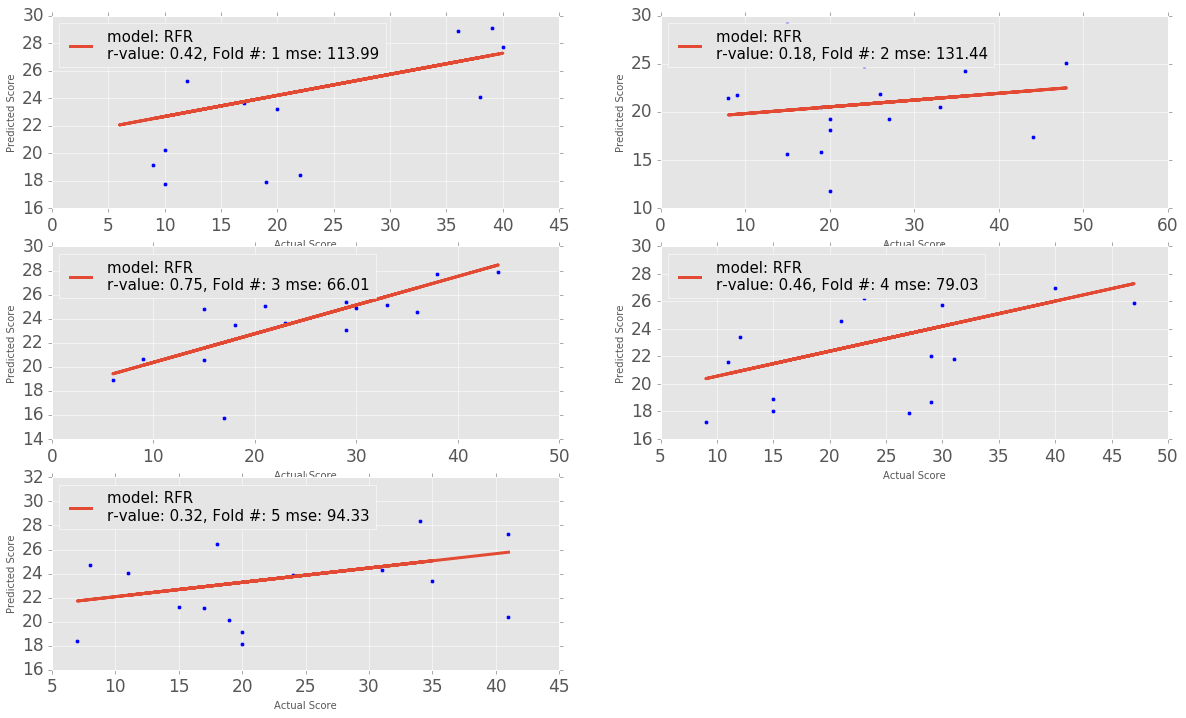

In [99]:
#plotting things and predicting scores
plt.rcParams['figure.figsize'] = (20, 20)
for k in range(0,5):
    
    x = y_test_list[k]
    y = y_predict_list[k]
    mse_fold = mse_list[k]
    
    plt.subplot(5,2,k+1)
    plt.scatter(x,y)
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    label_str = 'model: {}'.format(model_choice) + '\n' + 'r-value: {:04.2f}'.format(r_value) + ', Fold #: {}'.format(k+1) +' mse: {:04.2f}'.format(mse_fold)
    # fit_fn is now a function which takes in x and returns an estimate for y
    plt.plot(x, fit_fn(x),linewidth=3, label=label_str)
    
           
    plt.xlabel('Actual Score',fontsize=10)
    plt.ylabel('Predicted Score',fontsize=10)            
    plt.legend(fontsize=15,loc=2)
    plt.tick_params(labelsize=17)



#Save figure
save_fig = False
if save_fig:
    exp_name = 'GAFC_RFR'
    save_name = '{}{}{}_Plots.png'.format(baseline_dir,'data/MD/GAFC/12Up/RegressionPlots/', exp_name)
    print 'Save image path: ' + save_name
    box_fig = plt.gcf()
    box_fig.savefig(save_name)

In [ ]:
#correlation between FA values for each tract and prime score
import csv
import sys
#f = open("/projects/rutwik/PNC/ML/data/SOPS_Compare/FA+SOPS.csv", "w")

for i in range(5,35):
    frame = pd.read_csv(baseline_dir+csv_file, usecols=[3,i])
    matrix = frame.corr()
    #print matrix
    i+=1
 #   print 'correlation: {}'.format(matrix)
  #  print  >>f, matrix  


#matrix    
#f.close()


In [ ]:
#defined functions, keep at end


#Outer Fold Computation (need the imports inside def if you want to parallelize!)
def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, inner_loop, model_type):
    import collections
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import grid_search    
    import collections
    from scipy.stats import mode    
    from scipy import stats
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    
    if inner_loop:     
        print 'Starting InnerFold computation'    
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
    
    # Fit the best model based on inner loop performance
    clf.fit(train_X,train_y)
    pred_y = clf.predict(valid_X) #Specific label value
   # pred_y_prob = clf.predict_proba(valid_X) #Label probabilty (used for ROC)
    
    #feature imp (issue with the innerCVLoop)
    if model_type == 'RFR':
        feat_imp = clf.best_estimator_.feature_importances_
    elif model_type == 'LR_L1':
        feat_imp = clf.best_estimator_.coef_ 
    else: 
        print "Unknown model for computing feature importance. Setting it to zeros"
        feat_imp = np.zeros(len(pred_y))
        
    print 'Ending OuterFold computation'
    
    return {'actual_fold_scores':valid_y, 'predicted_fold_score': pred_y, 
            'hp_dict':hp_dict, 'feat_imp': feat_imp}

#Inner Fold Computation (need the imports inside def if you want to parallelize!)

def autolabel(rects,_ax):
    for rect in rects:
        height = rect.get_height()
        _ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{:03.2f}'.format(height),
                ha='center',            # vertical alignment
                va='bottom',             # horizontal alignment
                fontsize = 25)